# MIS 583 Assignment 4: Self-supervised and transfer learning on CIFAR10

Before we start, please put your name and SID in following format: <br>
: LASTNAME Firstname, ?00000000   //   e.g.) 李晨愷 M114020035

**Your Answer:**    
Hi I'm 游凱翔, M124020034.

## Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Setup (5 points)

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random


def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
        return img
    elif rot == 1: # 90 degrees rotation
        return torch.rot90(img, 1, (1, 2))
    elif rot == 2: # 180 degrees rotation
        return torch.rot90(img, 2, (1, 2))
    elif rot == 3: # 270 degrees rotation
        return torch.rot90(img, 3, (1, 2))
    else:
        raise ValueError('rotation should be 0, 1, 2, or 3 degrees')

class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128
trainset = CIFAR10Rotation(root='./data', train=True,download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)

testset = CIFAR10Rotation(root='./data', train=False,download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:10<00:00, 16519210.62it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Show some example images and rotated images with labels:

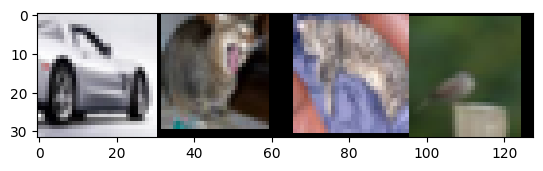

Class labels:  car   cat   cat   bird 


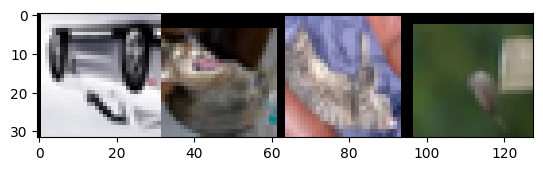

Rotation labels:  180   90    180   90   


In [ ]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

# Evaluation code

In [ ]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            #######################################################################
            # TODO: Calculate outputs by running images through the network       #
            # The class with the highest energy is what we choose as prediction   #
            #######################################################################
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            #######################################################################
            #                           End of your code                          #
            #######################################################################
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [ ]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train a ResNet18 on the rotation task (9 points)

In this section, we will train a ResNet18 model **from scratch** on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [ ]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device
device = torch.device('cuda')
device

device(type='cuda')

### 1  Notice: You should not use pretrained weights from ImageNet. 77.15 %

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(weights = None, num_classes=4) # Do not modify this line.
net = net.to(device)
print(net) # print your model and check the num_classes is correct

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch.nn as nn
import torch.optim as optim
################################################################################
# TODO: Define loss and optmizer functions                                     #
# Try any loss or optimizer function and learning rate to get better result    #
# hint: torch.nn and torch.optim                                               #
################################################################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
################################################################################
#                               End of your code                               #
################################################################################
criterion = criterion.to(device)

In [ ]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()
        net = net.to(device)
        net.train()
        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)
            ######################################################################################################
            # TODO: Set the data to the correct device; Different task will use different inputs and labels      #
            # TODO: Zero the parameter gradients                                                                 #
            # TODO: forward + backward + optimize                                                                #
            # TODO: Get predicted results                                                                        #
            ######################################################################################################
            imgs = imgs.to(device)
            imgs_rotated = imgs_rotated.to(device)
            rotation_label = rotation_label.to(device)
            cls_label = cls_label.to(device)

            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)
            if task == 'rotation':
                inputs, labels = imgs_rotated, rotation_label
            elif task == 'classification':
                inputs, labels = imgs, cls_label
            optimizer.zero_grad()  # zero the parameter gradients
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Get predicted results
            _, predicted = torch.max(outputs, 1)
            ######################################################################################################
            #                               End of your code                                                     #
            ######################################################################################################
            # print statistics
            print_freq = 100
            running_loss += loss.item()
            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()
        ######################################################################################################
        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.          #
        ######################################################################################################
        run_test(net, testloader, criterion, task)  # Call your test function here
        net.eval()
        ######################################################################################################
        #                               End of your code                                                     #
        ######################################################################################################
    print('Finished Training')

In [ ]:
train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='rotation')
################################
#     TODO: Save the model     #
################################
torch.save(net.state_dict(), 'rotation_model.pt')

################################
#      End of your code        #
################################

[1,   100] loss: 1.582 acc: 28.39 time: 6.34
[1,   200] loss: 1.303 acc: 43.48 time: 7.42
[1,   300] loss: 1.190 acc: 48.09 time: 6.12
TESTING:
Accuracy of the network on the 10000 test images: 52.55 %
Average loss on the 10000 test images: 1.119
[2,   100] loss: 1.126 acc: 50.78 time: 10.97
[2,   200] loss: 1.109 acc: 52.09 time: 10.79
[2,   300] loss: 1.091 acc: 52.59 time: 9.31
TESTING:
Accuracy of the network on the 10000 test images: 55.84 %
Average loss on the 10000 test images: 1.047
[3,   100] loss: 1.052 acc: 55.77 time: 8.13
[3,   200] loss: 1.031 acc: 55.84 time: 6.65
[3,   300] loss: 1.046 acc: 55.59 time: 7.91
TESTING:
Accuracy of the network on the 10000 test images: 59.20 %
Average loss on the 10000 test images: 0.974
[4,   100] loss: 0.999 acc: 57.84 time: 7.14
[4,   200] loss: 0.982 acc: 58.64 time: 8.08
[4,   300] loss: 0.961 acc: 59.38 time: 7.48
TESTING:
Accuracy of the network on the 10000 test images: 60.25 %
Average loss on the 10000 test images: 0.937
[5,   100]

## 2-1  Fine-tuning on the pre-trained model (9 points) 58.19 % 保留L4 FC曾  10類

In this section, we will load the ResNet18 model pre-trained on the rotation task and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

**Then we will use the trained model from rotation task as the pretrained weights. Notice, you should not use the pretrained weights from ImageNet.**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

#####################################################
#     TODO: Load the pre-trained ResNet18 model     #
#####################################################

# Load the pre-trained ResNet18 model
net = resnet18(pretrained=False,num_classes=4)

# 載入模型權重
net.load_state_dict(torch.load('rotation_model.pt', map_location='cpu'))

# 印修改前的模型
print("Original Model:")
print(net)

# 原始的fc層修改
fc_layers = [nn.Linear(512, 10)]

# 新fc層替換原始fc
net.fc = nn.Sequential(*fc_layers)

# 印修改後的模型
print("\nModified Model:")
print(net) # print your model and check the num_classes is correct

####################################################
#                End of your code                  #
####################################################

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Original Model:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(

In [ ]:
#################################################################################################
#   TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable     #
#################################################################################################
# Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
for name, param in net.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
#################################################################################################
#                                          End of your code                                     #
#################################################################################################

In [ ]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.0.weight
	 fc.0.bias


In [ ]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 1.837 acc: 32.21 time: 5.58
[1,   200] loss: 1.563 acc: 42.41 time: 7.19
[1,   300] loss: 1.500 acc: 44.83 time: 5.78
TESTING:
Accuracy of the network on the 10000 test images: 47.82 %
Average loss on the 10000 test images: 1.434
[2,   100] loss: 1.422 acc: 48.15 time: 6.41
[2,   200] loss: 1.375 acc: 50.03 time: 8.00
[2,   300] loss: 1.407 acc: 49.25 time: 6.43
TESTING:
Accuracy of the network on the 10000 test images: 50.95 %
Average loss on the 10000 test images: 1.356
[3,   100] loss: 1.370 acc: 50.27 time: 6.76
[3,   200] loss: 1.368 acc: 50.02 time: 5.45
[3,   300] loss: 1.331 acc: 51.33 time: 7.00
TESTING:
Accuracy of the network on the 10000 test images: 51.87 %
Average loss on the 10000 test images: 1.338
[4,   100] loss: 1.315 acc: 52.85 time: 6.68
[4,   200] loss: 1.311 acc: 52.72 time: 5.51
[4,   300] loss: 1.319 acc: 52.71 time: 6.58
TESTING:
Accuracy of the network on the 10000 test images: 52.44 %
Average loss on the 10000 test images: 1.308
[5,   100] l

## 2-2 Fine-tuning on the randomly initialized model (9 points) 46.29 %  跟前面得做比較 (正確) 10類
In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18
#################################################
# TODO: Randomly initialize a ResNet18 model    #
#################################################
# Randomly initialize a ResNet18 model

net = resnet18(pretrained=False,num_classes=10)

print(net) # print your model and check the num_classes is correct
#################################################
#              End of your code                 #
#################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#################################################################################################
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable       #
# To do this, you should set requires_grad=False for the frozen layers.                         #
#################################################################################################
# Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
for name, param in net.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
#################################################################################################
#                                          End of your code                                     #
#################################################################################################


In [ ]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [ ]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params_to_update, lr=0.1, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.256 acc: 25.05 time: 5.70
[1,   200] loss: 1.924 acc: 30.66 time: 6.84
[1,   300] loss: 1.863 acc: 32.68 time: 5.55
TESTING:
Accuracy of the network on the 10000 test images: 37.24 %
Average loss on the 10000 test images: 1.744
[2,   100] loss: 1.805 acc: 34.39 time: 5.98
[2,   200] loss: 1.779 acc: 35.72 time: 6.94
[2,   300] loss: 1.782 acc: 36.00 time: 5.86
TESTING:
Accuracy of the network on the 10000 test images: 38.92 %
Average loss on the 10000 test images: 1.698
[3,   100] loss: 1.744 acc: 36.75 time: 6.03
[3,   200] loss: 1.736 acc: 37.63 time: 6.54
[3,   300] loss: 1.740 acc: 36.99 time: 5.59
TESTING:
Accuracy of the network on the 10000 test images: 39.77 %
Average loss on the 10000 test images: 1.684
[4,   100] loss: 1.730 acc: 37.57 time: 6.93
[4,   200] loss: 1.705 acc: 38.31 time: 5.56
[4,   300] loss: 1.704 acc: 39.07 time: 6.75
TESTING:
Accuracy of the network on the 10000 test images: 40.59 %
Average loss on the 10000 test images: 1.654
[5,   100] l

## 3-1 Supervised training on the pre-trained model (9 points) 87 % 讀黨 直接train 10類
In this section, we will load the ResNet18 model pre-trained on the rotation task and re-train the whole model on the classification task.

**Then we will use the trained model from rotation task as the pretrained weights. Notice, you should not use the pretrained weights from ImageNet.**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

#####################################################
#     TODO: Load the pre-trained ResNet18 model     #
#####################################################

net = resnet18(pretrained=False,num_classes=4)

# 載入模型權重
net.load_state_dict(torch.load('rotation_model.pt', map_location='cpu'))

# 印修改前的模型
print("Original Model:")
print(net)

# 原始fc層修改
fc_layers = [nn.Linear(512, 10)]

# 新fc層替換原始fc
net.fc = nn.Sequential(*fc_layers)

# 印修改後的模型
print("\nModified Model:")
print(net) # print your model and check the num_classes is correct
#####################################################
#                End of your code                   #
#####################################################

Original Model:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(

In [ ]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.1, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/da

[1,   100] loss: 1.481 acc: 45.12 time: 7.07
[1,   200] loss: 1.185 acc: 57.73 time: 7.43
[1,   300] loss: 1.103 acc: 61.07 time: 6.50


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20><function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        self._shutdown_workers()
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    
if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    
if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a

TESTING:
Accuracy of the network on the 10000 test images: 65.60 %
Average loss on the 10000 test images: 0.995


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'
    AssertionError: if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/pro

[2,   100] loss: 0.961 acc: 65.96 time: 7.91
[2,   200] loss: 0.941 acc: 67.20 time: 6.06
[2,   300] loss: 0.911 acc: 68.36 time: 7.11


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorException ignored in: : can only test a child process<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/da

TESTING:
Accuracy of the network on the 10000 test images: 70.91 %
Average loss on the 10000 test images: 0.856


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

[3,   100] loss: 0.839 acc: 70.35 time: 7.01
[3,   200] loss: 0.822 acc: 70.94 time: 7.48
[3,   300] loss: 0.812 acc: 71.64 time: 6.21


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    
    self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/da

TESTING:
Accuracy of the network on the 10000 test images: 72.50 %
Average loss on the 10000 test images: 0.806


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
self._shutdown_workers()    
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
if w.is_alive():    
if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a

[4,   100] loss: 0.762 acc: 73.60 time: 7.82
[4,   200] loss: 0.747 acc: 73.90 time: 6.14
[4,   300] loss: 0.741 acc: 74.38 time: 7.00


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        if w.is_alive():self._shutdown_workers()

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: 
can only test a child process
  File "/usr/lib/

TESTING:
Accuracy of the network on the 10000 test images: 74.82 %
Average loss on the 10000 test images: 0.741


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>Exception ignored in: 
    Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
self._shutdown_workers()    self._shutdown_workers()  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

if w.is_alive():      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/d

[5,   100] loss: 0.689 acc: 76.20 time: 6.75
[5,   200] loss: 0.710 acc: 75.56 time: 7.32
[5,   300] loss: 0.698 acc: 75.67 time: 6.11


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

    Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    
if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a

TESTING:
Accuracy of the network on the 10000 test images: 75.68 %
Average loss on the 10000 test images: 0.715


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
self._shutdown_workers()
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
if w.is_alive():    if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.10/multiprocessing/process.py", line 1

[6,   100] loss: 0.647 acc: 77.47 time: 8.16
[6,   200] loss: 0.655 acc: 77.04 time: 6.44
[6,   300] loss: 0.668 acc: 77.19 time: 7.45


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>    self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 1

TESTING:
Accuracy of the network on the 10000 test images: 76.53 %
Average loss on the 10000 test images: 0.702


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a

[7,   100] loss: 0.630 acc: 78.10 time: 7.12
[7,   200] loss: 0.635 acc: 78.23 time: 7.29
[7,   300] loss: 0.607 acc: 78.86 time: 6.13


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>    
if w.is_alive():Traceback (most recent call last):

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'    
AssertionErrorself._shutdown_workers()
:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
can only test a child process
    Exception ignored in: <function _M

TESTING:
Accuracy of the network on the 10000 test images: 77.15 %
Average loss on the 10000 test images: 0.683


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        self._shutdown_workers()if w.is_alive():

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():

AssertionError: can only test a child process  File "/usr/lib/p

[8,   100] loss: 0.582 acc: 80.07 time: 7.89
[8,   200] loss: 0.602 acc: 79.18 time: 6.29
[8,   300] loss: 0.603 acc: 79.42 time: 7.43


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: 
can only test a child processException ignored

TESTING:
Accuracy of the network on the 10000 test images: 77.46 %
Average loss on the 10000 test images: 0.671


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c4f756c20>

Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    can only test a child processself._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

[9,   100] loss: 0.562 acc: 80.76 time: 7.81
[9,   200] loss: 0.581 acc: 79.74 time: 7.56
[9,   300] loss: 0.573 acc: 80.41 time: 6.24
TESTING:
Accuracy of the network on the 10000 test images: 78.63 %
Average loss on the 10000 test images: 0.645
[10,   100] loss: 0.535 acc: 81.48 time: 6.58
[10,   200] loss: 0.561 acc: 80.73 time: 6.90
[10,   300] loss: 0.545 acc: 81.35 time: 8.26
TESTING:
Accuracy of the network on the 10000 test images: 78.55 %
Average loss on the 10000 test images: 0.631
[11,   100] loss: 0.477 acc: 83.93 time: 7.64
[11,   200] loss: 0.444 acc: 84.84 time: 6.29
[11,   300] loss: 0.421 acc: 85.55 time: 7.39
TESTING:
Accuracy of the network on the 10000 test images: 81.10 %
Average loss on the 10000 test images: 0.568
[12,   100] loss: 0.432 acc: 84.95 time: 6.53
[12,   200] loss: 0.419 acc: 85.58 time: 7.26
[12,   300] loss: 0.416 acc: 85.59 time: 6.40
TESTING:
Accuracy of the network on the 10000 test images: 81.33 %
Average loss on the 10000 test images: 0.565
[13

## 3-2 Supervised training on the randomly initialized model (9 points) 80.50 % 不讀檔  10類 不false
In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

#################################################
# TODO: Randomly initialize a ResNet18 model    #
#################################################

# Randomly initialize a ResNet18 model
net = resnet18(pretrained=False,num_classes=10)

print(net) # print your model and check the num_classes is correct
#################################################
#              End of your code                 #
#################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.253 acc: 23.69 time: 7.36
[1,   200] loss: 1.887 acc: 32.40 time: 5.87
[1,   300] loss: 1.739 acc: 36.23 time: 7.07
TESTING:
Accuracy of the network on the 10000 test images: 43.59 %
Average loss on the 10000 test images: 1.546
[2,   100] loss: 1.544 acc: 43.48 time: 6.02
[2,   200] loss: 1.463 acc: 47.09 time: 6.97
[2,   300] loss: 1.384 acc: 50.22 time: 5.99
TESTING:
Accuracy of the network on the 10000 test images: 52.87 %
Average loss on the 10000 test images: 1.303
[3,   100] loss: 1.283 acc: 53.30 time: 6.31
[3,   200] loss: 1.239 acc: 55.50 time: 7.30
[3,   300] loss: 1.199 acc: 57.23 time: 6.39
TESTING:
Accuracy of the network on the 10000 test images: 60.42 %
Average loss on the 10000 test images: 1.104
[4,   100] loss: 1.125 acc: 59.14 time: 7.39
[4,   200] loss: 1.093 acc: 60.91 time: 5.89
[4,   300] loss: 1.087 acc: 61.42 time: 6.99
TESTING:
Accuracy of the network on the 10000 test images: 65.50 %
Average loss on the 10000 test images: 0.983
[5,   100] l

# Write report (37 points)

本次作業主要有3個tasks需要大家完成，在A4.pdf中有希望大家達成的baseline **(不能低於baseline最多2%，沒有達到不會給全部分數)**，report的撰寫請大家根據以下要求完成，就請大家將嘗試的結果寫在report裡，祝大家順利！

1. (13 points) Train a ResNet18 on the Rotation task and report the test performance. Discuss why such a task helps in learning features that are generalizable to other visual tasks.

2. (12 points) Initializing from the Rotation model or from random weights, fine-tune only the weights of the final block of convolutional layers and linear layer on the supervised CIFAR10 classification task. Report the test results and compare the performance of these two models. Provide your observations and insights. You can also discuss how the performance of pre-trained models affects downstream tasks, the performance of fine-tuning different numbers of layers, and so on.

3. (12 points) Initializing from the Rotation model or from random weights, train the full network on the supervised CIFAR10 classification task. Report the test results and compare the performance of these two models. Provide your observations and insights.

（13分）在旋轉任務上訓練一個ResNet18並報告測試性能。討論為什麼這樣的任務有助於學習對其他視覺任務具有泛化能力的特徵。

（12分）從旋轉模型或隨機權重初始化，僅微調最後一個卷積層塊和線性層的權重，在監督式CIFAR10分類任務中報告測試結果並比較這兩種模型的性能。提供您的觀察和見解。您還可以討論預訓練模型的性能如何影響下游任務、微調不同數量層次的性能等。

（12分）從旋轉模型或隨機權重初始化，將完整網絡用於監督式CIFAR10分類任務上進行訓練。報告測試結果並比較這兩種模型的性能。提供您的觀察和見解。

# Extra Credit (13 points)

上面基本的code跟report最高可以拿到87分，這個加分部分並沒有要求同學們一定要做，若同學們想要獲得更高的分數可以根據以下的加分要求來獲得加分。

- In Figure 5(b) from the Gidaris et al. paper, the authors show a plot of CIFAR10 classification performance vs. number of training examples per category for a supervised CIFAR10 model vs. a RotNet model with the final layers fine-tuned on CIFAR10. The plot shows that pre-training on the Rotation task can be advantageous when only a small amount of labeled data is available. Using your RotNet fine-tuning code and supervised CIFAR10 training code from the main assignment, try to create a similar plot by performing supervised fine-tuning/training on only a subset of CIFAR10.
- Use a more advanced model than ResNet18 to try to get higher accuracy on the rotation prediction task, as well as for transfer to supervised CIFAR10 classification.
  
- If you have a good amount of compute at your disposal, try to train a rotation prediction model on the larger ImageNette dataset (still smaller than ImageNet, though).
